In [ ]:
!зщуекн 

# Emergency Datahack: треки и данные<a class="anchor" id="0-bullet">

* [Задачи и метрики](#зм-bullet)
* [Сдача ответа](#фо-bullet)
* [Данные](#д-bullet)
* [Тайминг хакатона](#т-bullet)

In [1]:
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import scipy.stats as stats

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Задачи и метрики<a class="anchor" id="зм-bullet"></a>
[назад к оглавлению](#0-bullet)

### Треки 1 и 2: общее

#### Цели 

Обе задачи связаны с предсказанием заторов на реке Лена.
Нас интересуют гидропосты в одних и тех же населённых пунктах: Киренск, Витим, Пеледуй, Крестовский Лесоучасток, Ленск, Олёкминск, Покровск, Якутск, Батамай, Сангар.

#### Источники данных

Метео- и гидроданные Росгидромета.

#### Критерии оценки 

<div class="alert alert-block alert-success">
(внимание, обновление!)
</div>

**60 баллов** распределяется в соответствии с результатом, который ML-модель показала на соревновании. Будет учитываться не место в турнирной таблице напрямую, а логарифмированное значение ошибки на тестовой выборке относительно величины ошибок других участников. По результатам соревнования на очную защиту перед жюри допускается не более 10 команд.

**40 баллов** распределяется по результатам оценки кода, выложенного в открытый репозиторий, а также выступления на очной защите в соответствии со следующими критериями:

- обоснованность выбранных методов решения задачи с точки зрения гидрологии и применимости итоговой модели в работе МЧС (20 баллов);
- оригинальность подхода, в частности, использование дополнительных данных из открытых источников для повышения качества модели (10 баллов);
- качество кода: его чистота и понятность (5 баллов);
- качество очной защиты: последовательность и понятность изложения (5 баллов).

**Ожидаемые результаты**

- Краткая аннотация проекта (описание проекта в 2-4 предложениях);
- ML-модель, обученная на тренировочной выборке (сдается на платформе);
- Код, использованный при подготовке модели 
(ссылка на любой открытый репозиторий с кодом, с помощью которого строилась модель, а также кодом, запускающим модель);
- Презентация результатов решения (pptx/pdf/ipynb/...).

### Треки 1 и 2: различное

|  | **Трек 1** :| **Трек 2** :|
|:--------------|--------------:|--------------:|
| **Что предсказываем** | Вероятность затора | Изменение максимального уровня воды |
| **Прогноз** | Заблаговременный (готов 15 февраля)| Оперативный (на неделю вперёд) |
| **Горизонт планирования** | на каждый из 45 дней | на 7 дней |
| **Как часто строим** | 1 раз в год | Каждый день в нужном интервале |
| **Тестовый период** | 21 апреля – 3 июня | 21 апреля – 15 июня |
| **Какие данные доступны** | Только исторические | Исторические + прогноз погоды |
| **В чём заключается задача** | Выбор фичей и классификация | Прогнозирование временных рядов |
| **Самое интересное** | Предсказание редких событий с небольшой обучающей выборкой | Последовательное получение данных |

### Подробнее о метриках

#### Трек #1 (Gini coefficient)

<div class="alert alert-block alert-success">
Не путать с экономическим индексом Джини :)
</div>

Самые популярные метрики оценивания качества классификации – `precision` и `recall` – плохо работают в случае предсказания редких событий.

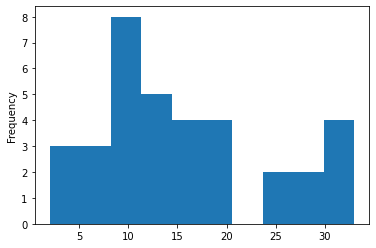

In [3]:
# Суммарная продолжительность по всем гидропостам
ice_jam_duration_by_year = pd.read_csv('present_ice_jams.csv')
_ = ice_jam_duration_by_year['ice_jam'].plot.hist()

Частое решение – использование метрики `F1`, но `F1` зависит от выбора порога отсечения, используемого командой.

При таком долгосрочном прогнозе нам важнее получить распредление вероятностей и выбрать оптимальный порог уже после того, как определится победитель. Такую возможность предоставляет вычисление метрики `ROC-AUC` – площади под кривой, определяющей пропорцию правильно и неправильно угаданных классов по вероятности.

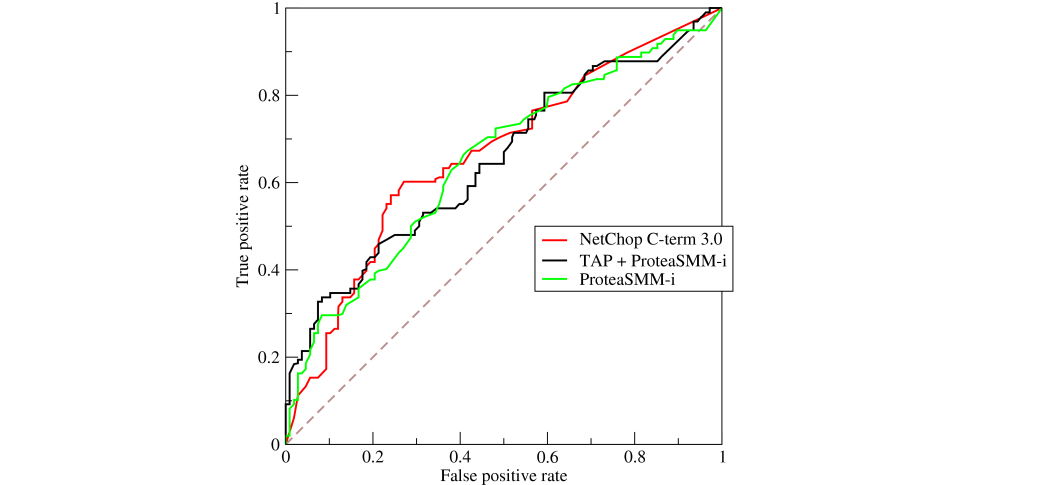

Индекс Джини вычисляется по формуле: `Gini_coeff := 2 * ROC_AUC - 1`

<div class="alert alert-block alert-success">
Важно: значение коэффициента Джини считается сразу по всем гидропостам.
</div>

#### Трек #2 (Normalised MSE)

На графике видно, что у каждого гидропоста возможна своя дельта –– а также, что пики возникают очень резко.
В связи с этим мы выбрали `Mean Squared Error`, для каждого из гидропостов нормированную на стандартное отклонение колебаний величины дельты на этом гидропосте.

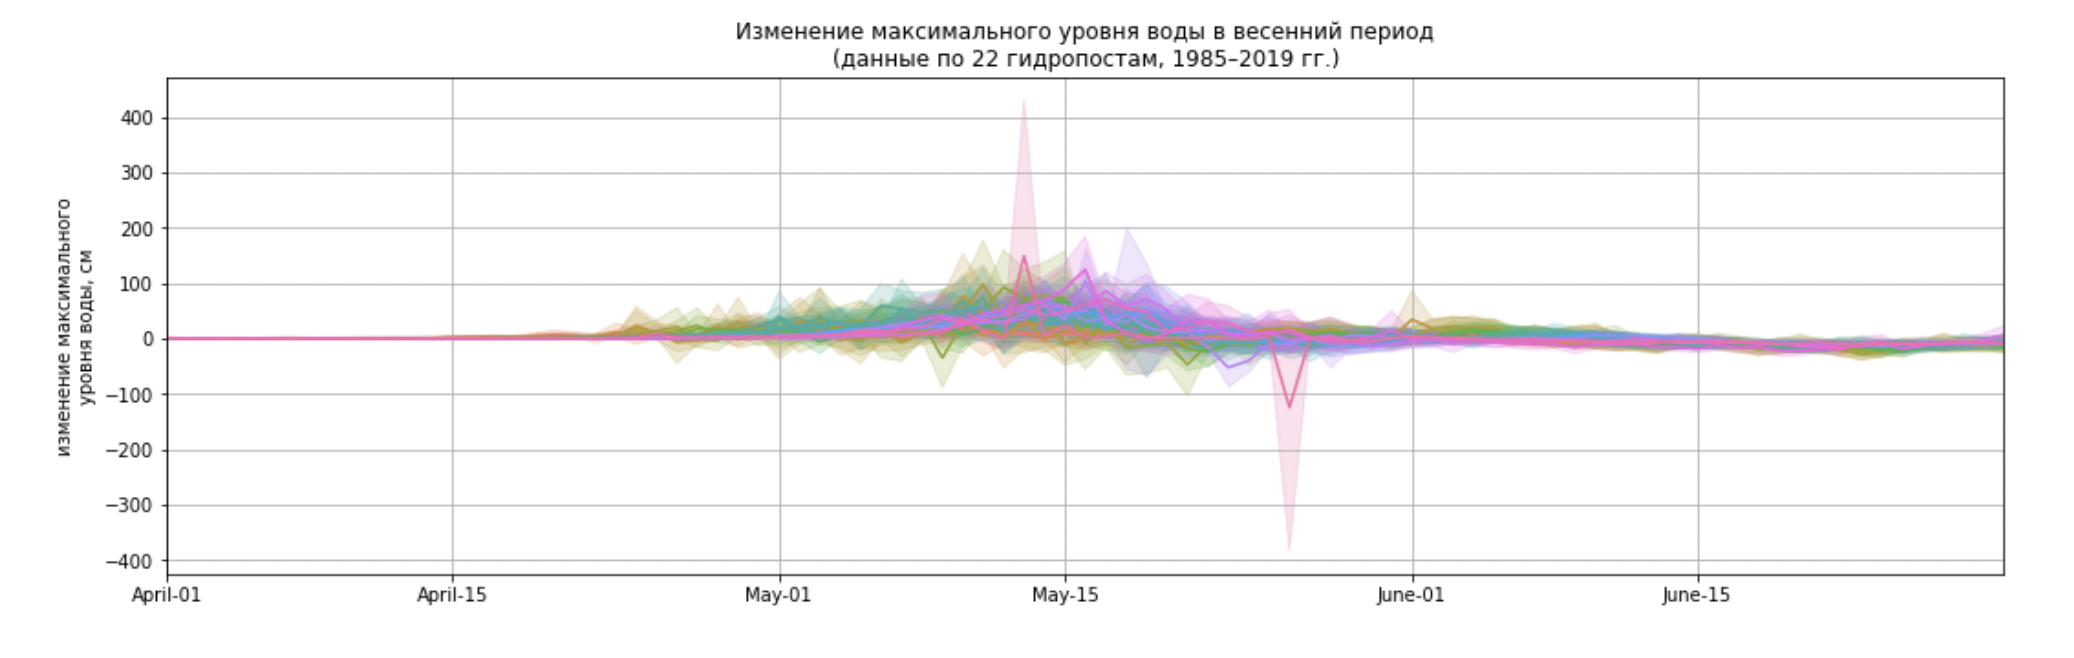

## Сдача ответа<a class="anchor" id="фо-bullet"></a>
[назад к оглавлению](#0-bullet)

**Трек#1**

Всё стандартно: вначале выдается тренировочная выборка и тестовая выборка с пропущенными значениями целевой переменной. По мере обновления модели нужно будет загружать в систему `csv`-файлы с проставленными значения целевой переменной.

**Трек#2**

Поскольку прогноз нужен каждый день на 7 дней вперёд, мы не выдаём сразу всей тестовой выборки, а делим её на четыре части. Тестовый период состоит из 8 недель, и из каждой пары недель в годы, попавшие в тестовую выборку, мы выбрали по одной неделе. Тестовая выборка будет выдаваться в 4 этапа:

- 18:20 (28 мая) Первые 2 недели (сразу после старта хакатона)
- 10:00 (29 мая) Вторые 2 недели + все предыдущее (перед первым чекпоинтом)
- 15:00 (29 мая) Третьи 2 недели + все предыдущее
- 20:00 (29 мая) Четвертые 2 недели + все предыдущее (после второго чекпоинта)

<div class="alert alert-block alert-success">
Итоговый скор будет считаться по самой поздней тестовой выборке.
</div>

## Данные<a class="anchor" id="д-bullet"></a>
[назад к оглавлению](#0-bullet)

1) Тематика основных данных:

- гидрологические: наблюдения с 27 гидропостов на реке Лене и **ее притоках**
- метеорологические: наблюдения с 38 метеостанций в окрестностях гидропостов

Дополнительные данные: географические координаты наблюдательных пунктов, пара справочников с расшифровкой кодов.

2) Географический разброс: [см. карту](https://www.google.com/maps/d/edit?mid=1YvHHeK9-lMww5gw2cOY4EQMyvN6gpqUb&usp=sharing)

3) Временной период: 1 января 1985 г. — 31 декабря 2019 г.

4) Наборы файлов — **трек #1**:

In [4]:
directory = '/home/common/emergency_datahack/data_processed/samples/track_1/'

# гидро
hydro_1day = pd.read_csv(directory + 'hydro_1day_sample.csv')
hydro_coord = pd.read_csv(directory + 'hydro_coord_sample.csv')

# метео — обратите внимание на различие во временной детализации
meteo_3hours = pd.read_csv(directory + 'meteo_3hours_sample.csv')
meteo_1day = pd.read_csv(directory + 'meteo_1day_sample.csv')
meteo_1month = pd.read_csv(directory + 'meteo_1month_sample.csv')
meteo_coord = pd.read_csv(directory + 'meteo_coord_sample.csv')

# справочники
reference_water_codes = pd.read_csv(directory + 'reference_water_codes_sample.csv')
reference_horiz_visib = pd.read_csv(directory + 'reference_horiz_visib_sample.csv')

# тест и трейн
train_tr1 = pd.read_csv(directory + 'train_sample.csv')
test_tr1 = pd.read_csv(directory + 'test_sample.csv')

In [5]:
# коды заторов содержатся в поле water_code
hydro_1day.head()

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,discharge
0,2006,3036,11,334,2006-11-30,322.0,319.0,325.0,0.0,16,23.0,17.0,1.0,2000.0
1,2012,3042,11,335,2012-11-30,212.0,212.0,212.0,0.0,46,56.0,12.0,1.0,1950.0
2,2019,3036,11,324,2019-11-20,221.0,203.0,239.0,0.0,46,18.0,5.0,1.0,2110.0
3,2012,3106,11,335,2012-11-30,220.0,220.0,220.0,0.0,46,45.0,24.0,1.0,314.0
4,1993,3169,10,304,1993-10-31,354.0,354.0,354.0,0.0,46,16.0,1.0,1.0,368.0


In [6]:
hydro_coord.head()

,station_id,name,lat,lon,distance_from_source,drainage_area,z_null
0,3032,МАЧА (ГП ПРИ МАЧА М) - Р.ЛЕНА,59.930000,117.600000,1981.0,538000,138.90
1,3041,ПОКРОВСК - Р.ЛЕНА,61.470000,129.170000,2720.0,892000,88.91
2,3035,ОЛЕКМИНСК - Р. ЛЕНА,60.366667,120.416667,2191.0,560000,122.72
3,3169,КУДУ-КЮЕЛЬ - Р.ОЛЕКМА,59.370000,121.320000,1280.0,115000,135.01
4,3019,КИРЕНСК - Р.ЛЕНА,57.770000,108.070000,1140.0,92200,249.38


In [7]:
# много категориальных переменных
meteo_3hours.head()

,station_id,year_GMT,month_GMT,day_GMT,synop_hour_GMT,year_local,month_local,day_local,synop_hour_local,synop_hour_order_PDZV,time_local,timezone,meteo_day_start_PDZV,source_index,horizontal_visibility,horizontal_visibility_qual,horizontal_visibility_qual_1,cloud_amount_total,cloud_amount_total_qual,cloud_amount_low_level,cloud_amount_low_level_qual,cloud_form_high_level,cloud_form_high_level_qual,cloud_form_middle_level,cloud_form_middle_level_qual,cloud_form_vertical_develop,cloud_form_vertical_develop_qual,cloud_form_strat_stratocum,cloud_form_strat_stratocum_qual,cloud_form_strat_rain,cloud_form_strat_rain_qual,cloud_base_altitude,cloud_base_altitude_qual,cloud_base_altitude_qual_1,cloud_below_station,cloud_below_station_qual,soil_surface_condition,soil_surface_condition_qual,weather_before,weather_before_qual,weather,weather_qual,wind_direction,wind_direction_qual,wind_speed_aver,wind_speed_aver_qual,wind_speed_aver_qual_1,wind_speed_max,wind_speed_max_qual,wind_speed_max_qual_1,precipitation,precipitation_qual,soil_surface_temperature,soil_surface_temperature_qual,soil_surface_alco_temperature,soil_surface_alco_temperature_qual,soil_surface_temperature_min_before,soil_surface_temperature_min_before_qual,soil_surface_temperature_max_before,soil_surface_temperature_max_before_qual,soil_surface_max_temperature,soil_surface_max_temperature_qual,air_temperature,air_temperature_qual,air_temperature_wet_bulb,air_temperature_wet_bulb_qual,air_temperature_wet_bulb_qual_1,air_temperature_min_alco_temperature,air_temperature_min_alco_temperature_qual,air_temperature_min_before,air_temperature_min_before_qual,air_temperature_max_before,air_temperature_max_before_qual,air_max_temperature,air_max_temperature_qual,water_vapour_partial_pressure,water_vapour_partial_pressure_qual,water_vapour_partial_pressure_qual_1,relative_humidity,relative_humidity_qual,vapour_pressure_deficit,vapour_pressure_deficit_qual,vapour_pressure_deficit_qual_1,dew_point_temperature,dew_point_temperature_qual,pressure,pressure_qual,pressure_sea_level,pressure_sea_level_qual,barometric_tendency_characteristic,barometric_tendency_characteristic_qual,barometric_tendency,barometric_tendency_qual,date_local
0,24538,1985,7,7,0,1985,7,188,3,4,9,8,21,4,71.0,0,0.0,10.0,0,10.0,0,8.0,0,8.0,0,2.0,0,0.0,0,0.0,0,600.0,0,1.0,0.0,7,1.0,0,8.0,0,80.0,0,0.0,0,0.0,0,0,8.0,0,0,0.6,0,8.0,0,8.0,0,8.0,0,8.3,0,8.0,0,7.6,0,7.2,0,0,7.6,0,7.6,0,9.0,0,7.6,0,9.8,0,1,94.0,0,0.6,0,1,6.7,0,980.2,0,996.8,0,7.0,0,1.0,0,1985-07-07
1,24538,1985,7,23,0,1985,7,204,3,4,9,8,21,4,81.0,0,0.0,10.0,0,6.0,0,1.0,0,0.0,0,2.0,0,0.0,0,0.0,0,700.0,0,1.0,0.0,7,0.0,0,8.0,0,80.0,0,320.0,0,1.0,0,0,4.0,0,0,0.0,0,19.0,0,19.0,0,12.8,0,19.1,0,19.1,0,16.8,0,14.4,0,0,16.8,0,12.0,0,16.9,0,16.9,0,14.5,0,1,76.0,0,4.6,0,1,12.5,0,990.5,0,1006.7,0,8.0,0,0.7,0,1985-07-23
2,24538,1985,7,29,0,1985,7,210,3,4,9,8,21,4,81.0,0,0.0,10.0,0,10.0,0,8.0,0,8.0,0,2.0,0,2.0,0,0.0,0,700.0,0,1.0,0.0,7,0.0,0,8.0,0,80.0,0,40.0,0,4.0,0,0,8.0,0,0,0.0,0,9.5,0,9.5,0,9.5,0,9.7,0,9.5,0,8.0,0,7.5,0,0,8.0,0,8.0,0,9.0,0,8.0,0,10.0,0,1,93.0,0,0.7,0,1,7.0,0,998.4,0,1015.3,0,2.0,0,1.6,0,1985-07-29
3,24538,1985,8,8,0,1985,8,220,3,4,9,8,21,4,74.0,0,0.0,10.0,0,10.0,0,8.0,0,8.0,0,2.0,0,0.0,0,0.0,0,700.0,0,1.0,0.0,7,1.0,0,8.0,0,81.0,0,315.0,0,1.0,0,0,5.0,0,0,1.4,0,11.0,0,11.0,0,10.5,0,11.0,0,11.0,0,10.5,0,10.4,0,0,10.6,0,10.6,0,10.9,0,10.6,0,12.5,0,1,98.0,0,0.2,0,1,10.3,0,988.6,0,1005.2,0,2.0,0,1.7,0,1985-08-08
4,24538,1985,8,19,0,1985,8,231,3,4,9,8,21,4,78.0,0,0.0,12.0,0,12.0,0,0.0,0,0.0,0,2.0,0,0.0,0,0.0,0,600.0,0,1.0,0.0,7,1.0,0,2.0,0,81.0,0,40.0,0,4.0,0,0,8.0,0,0,0.7,0,15.3,0,15.3,0,11.5,0,15.3,0,15.3,0,14.0,0,13.3,0,0,14.0,0,13.3,0,14.0,0,14.0,0,14.7,0,1,92.0,0,1.3,0,1,12.7,0,991.3,0,1007.7,0,7.0,0,0.3,0,1985-08-19


In [8]:
meteo_1day.head()

,station_id,year,month,day,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_20cm_qual,temperature_40cm,temperature_40cm_qual,temperature_80cm,temperature_80cm_qual,temperature_120cm,temperature_120cm_qual,temperature_160cm,temperature_160cm_qual,temperature_240cm,temperature_240cm_qual,temperature_320cm,temperature_320cm_qual,temperature_ks_5cm,temperature_ks_5cm_qual,temperature_ks_10cm,temperature_ks_10cm_qual,temperature_ks_15cm,temperature_ks_15cm_qual,temperature_ks_20cm,temperature_ks_20cm_qual,date
0,30493,2000,11,331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,10.0,0.0,0.0,0.0,-97.0,0.0,-63.0,0.0,9999.0,9.0,-1.0,0.0,80.0,1.0,9999.0,9.0,9999.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-26
1,31004,1986,10,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986-10-19
2,30253,2001,8,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-08-12
3,30253,1989,12,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989-12-15
4,30328,1998,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,10.0,0.0,0.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,32.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,1998-01-09


In [9]:
# здесь в том числе есть продолжительность солнечного сияния за месяц
meteo_1month.head()

,station_id,year,month,data_qual,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours,date,day
0,30219,2004,7,0.0,88.7,89.3,88.8,0.5,0.0,236.0,2004-07-01,183
1,24817,2000,2,0.0,7.2,9.8,0.0,0.0,9.8,176.0,2000-02-01,32
2,30328,2010,1,0.0,24.2,24.2,0.0,0.0,24.2,60.0,2010-01-01,1
3,30219,1985,9,0.0,43.7,44.6,44.2,0.4,0.0,147.0,1985-09-01,244
4,30054,2012,7,0.0,83.6,84.8,84.8,0.0,0.0,283.0,2012-07-01,183


In [10]:
meteo_coord.head()

,station_id,name,lat,lon,z
0,30493,НАГОРНЫЙ,55.948258,124.915752,845.0
1,31102,КАНКУ,57.650000,125.966667,1204.0
2,24671,ТОМПО,63.950000,135.866667,399.0
3,24951,ИСИТЬ,60.820000,125.320000,123.0
4,30393,ЧУЛЬМАН,56.830000,124.870000,855.0


In [11]:
# коды режимных групп из water_code с расшифровкой
reference_water_codes.head()

,water_code,descr,group,phase
0,20,Лед на дне,NaN,ледостав (зима)
1,42,Зажор ниже поста,NaN,замерзание (осень)
2,50,Период ледостава (коды самостоятельного значения не имеют),NaN,ледостав (зима)
3,13,Плавучий лед,NaN,замерзание (осень)
4,46,Ледостав с торосами,NaN,ледостав (зима)


In [12]:
# справочная таблица для одного из признаков в meteo_3hours
reference_horiz_visib.head()

,code,km
0,73,23
1,22,2.2
2,77,27
3,78,28
4,0,< 0.1


In [13]:
# явно вынесли поле ice_jam с 1 и 0 — был затор или не было
# (нас интересуют только заторы ниже поста, т.к. они ведут к затоплению территории, из которой ведется наблюдение)
train_tr1.head()

,year,station_id,day,ice_jam
0,1991,3030,27,0.0
1,1992,3019,21,0.0
2,1998,3028,36,0.0
3,2008,3045,41,0.0
4,2011,3030,30,0.0


In [14]:
# для сабмита нужно заполнить поле ice_jam в тестовой выборке
test_tr1.head()

,year,station_id,day,ice_jam
0,1997,3045,4,NaN
1,2003,3050,39,NaN
2,2001,3028,25,NaN
3,2005,3028,35,NaN
4,1997,3230,43,NaN


5) Наборы файлов — **трек #2**:

In [15]:
directory = '/home/common/emergency_datahack/data_processed/samples/track_2/'

# гидро
train_tr2 = pd.read_csv(directory + 'train_sample.csv')
hydro_coord = pd.read_csv(directory + 'hydro_coord_sample.csv')

# метео — обратите внимание на различие во временной детализации
meteo_3hours = pd.read_csv(directory + 'meteo_3hours_sample.csv')
meteo_1day = pd.read_csv(directory + 'meteo_1day_sample.csv')
meteo_1month = pd.read_csv(directory + 'meteo_1month_sample.csv')
meteo_coord = pd.read_csv(directory + 'meteo_coord_sample.csv')

# справочники
reference_water_codes = pd.read_csv(directory + 'reference_water_codes_sample.csv')
reference_horiz_visib = pd.read_csv(directory + 'reference_horiz_visib_sample.csv')

In [16]:
# по сравнению с первым треком явно введено поле с таргетом — delta_stage_max
train_tr2.head()

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,discharge,year,month,day,delta_stage_max
0,3021,1985-04-10,107.0,106.0,107.0,0.0,16,94.0,27.0,1.0,245.0,1985,4,100,1.0
1,3021,1985-04-20,132.0,130.0,134.0,0.1,16,87.0,16.0,1.0,281.0,1985,4,110,7.0
2,3021,1986-04-10,113.0,113.0,113.0,0.0,14,86.0,56.0,1.0,280.0,1986,4,100,0.0
3,3021,1986-04-20,118.0,118.0,118.0,0.0,14,87.0,43.0,1.0,295.0,1986,4,110,0.0
4,3021,1987-04-10,97.0,97.0,97.0,0.0,14,77.0,47.0,1.0,229.0,1987,4,100,0.0


In [17]:
# # то же, что и в первом треке
# display(hydro_coord.head())
# display(meteo_3hours.head())
# display(meteo_1day.head())
# display(meteo_1month.head())
# display(meteo_coord.head())
# display(reference_water_codes.head())
# display(reference_horiz_visib.head())

In [18]:
# что дополнительно открываем в течение хакатона

directory = '/home/common/emergency_datahack/data_processed/samples/track_2/extra_sample/'

# исторические гидро- и метеоданные продляем до новой тестовой недели
extra_train_tr2 = pd.read_csv(directory + 'extra_train_sample.csv')
extra_meteo_3hours = pd.read_csv(directory + 'extra_meteo_3hours_sample.csv')
extra_meteo_1day = pd.read_csv(directory + 'extra_meteo_1day_sample.csv')
extra_meteo_1month = pd.read_csv(directory + 'extra_meteo_1month_sample.csv')

# для тестовой недели у нас в распоряжении есть еще и прогноз погоды
test_tr2 = pd.read_csv(directory + 'test_sample.csv', index_col=0)
forecast_meteo_3hours = pd.read_csv(directory + 'forecast_meteo_3hours_sample.csv', index_col=0)

In [19]:
# исторические гидро- и метеоданные продляем до новой тестовой недели

display(extra_train_tr2.head())
display(extra_meteo_3hours.head())
display(extra_meteo_1day.head())
display(extra_meteo_1month.head())  # тут может быть пустая таблица — если за этот месяц данные у вас уже есть

,year,station_id,month,day,date,delta_stage_max,discharge,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place
0,1989,3019,4,111,1989-04-21,0.0,56.0,56.0,56.0,0.0,16,NaN,NaN,NaN,NaN
1,1989,3019,4,112,1989-04-22,0.0,56.0,56.0,56.0,0.0,16,NaN,NaN,NaN,NaN
2,1989,3019,4,113,1989-04-23,0.0,56.0,55.0,56.0,0.0,16,NaN,NaN,NaN,NaN
3,1989,3019,4,114,1989-04-24,-1.0,55.0,54.0,55.0,0.0,16,NaN,NaN,NaN,NaN
4,1989,3019,4,115,1989-04-25,-2.0,53.0,52.0,53.0,0.0,16,74.0,0.0,1.0,NaN


,station_id,year_GMT,month_GMT,day_GMT,synop_hour_GMT,year_local,month_local,day_local,synop_hour_local,synop_hour_order_PDZV,time_local,timezone,meteo_day_start_PDZV,source_index,horizontal_visibility,horizontal_visibility_qual,horizontal_visibility_qual_1,cloud_amount_total,cloud_amount_total_qual,cloud_amount_low_level,cloud_amount_low_level_qual,cloud_form_high_level,cloud_form_high_level_qual,cloud_form_middle_level,cloud_form_middle_level_qual,cloud_form_vertical_develop,cloud_form_vertical_develop_qual,cloud_form_strat_stratocum,cloud_form_strat_stratocum_qual,cloud_form_strat_rain,cloud_form_strat_rain_qual,cloud_base_altitude,cloud_base_altitude_qual,cloud_base_altitude_qual_1,cloud_below_station,cloud_below_station_qual,soil_surface_condition,soil_surface_condition_qual,weather_before,weather_before_qual,weather,weather_qual,wind_direction,wind_direction_qual,wind_speed_aver,wind_speed_aver_qual,wind_speed_aver_qual_1,wind_speed_max,wind_speed_max_qual,wind_speed_max_qual_1,precipitation,precipitation_qual,soil_surface_temperature,soil_surface_temperature_qual,soil_surface_alco_temperature,soil_surface_alco_temperature_qual,soil_surface_temperature_min_before,soil_surface_temperature_min_before_qual,soil_surface_temperature_max_before,soil_surface_temperature_max_before_qual,soil_surface_max_temperature,soil_surface_max_temperature_qual,air_temperature,air_temperature_qual,air_temperature_wet_bulb,air_temperature_wet_bulb_qual,air_temperature_wet_bulb_qual_1,air_temperature_min_alco_temperature,air_temperature_min_alco_temperature_qual,air_temperature_min_before,air_temperature_min_before_qual,air_temperature_max_before,air_temperature_max_before_qual,air_max_temperature,air_max_temperature_qual,water_vapour_partial_pressure,water_vapour_partial_pressure_qual,water_vapour_partial_pressure_qual_1,relative_humidity,relative_humidity_qual,vapour_pressure_deficit,vapour_pressure_deficit_qual,vapour_pressure_deficit_qual_1,dew_point_temperature,dew_point_temperature_qual,pressure,pressure_qual,pressure_sea_level,pressure_sea_level_qual,barometric_tendency_characteristic,barometric_tendency_characteristic_qual,barometric_tendency,barometric_tendency_qual,date_local
0,24641,2003,4,24,0,2003,4,114,0,4,9,8,20,4,97.0,0,0.0,10.0,0,7.0,0,8.0,0,2.0,0,4.0,0,0.0,0,0.0,0,390.0,0,0.0,0.0,7,3.0,0,8.0,0,85.0,0,220.0,0,4.0,0,0,9.0,0,0,0.6,0,-4.4,0,-4.8,0,-9.5,0,-4.2,0,-4.4,0,-5.4,0,-6.3,0,1,-5.5,0,-5.9,0,-4.9,0,-5.2,0,2.96,0,2,72.0,0,1.13,0,2,-9.6,0,975.9,0,989.8,0,2.0,0,0.7,0,2003-04-24
1,24641,2013,4,23,0,2013,4,113,0,4,9,8,20,4,98.0,0,0.0,10.0,0,3.0,0,5.0,0,1.0,0,2.0,0,0.0,0,0.0,0,800.0,0,1.0,0.0,7,2.0,0,8.0,0,85.0,0,350.0,0,2.0,0,0,5.0,0,0,0.0,0,-0.5,0,-0.5,0,-7.0,0,-0.2,0,-0.2,0,-0.7,0,-1.3,0,1,-0.7,0,-4.4,0,-0.5,0,-0.5,0,5.06,0,2,87.0,0,0.74,0,2,-2.6,0,1001.4,0,1015.4,0,2.0,0,1.2,0,2013-04-23
2,24643,2005,4,24,0,2005,4,114,0,4,9,8,20,4,95.0,0,0.0,10.0,0,10.0,0,8.0,0,8.0,0,2.0,0,0.0,0,0.0,0,700.0,0,1.0,0.0,7,4.0,0,8.0,0,86.0,0,325.0,0,3.0,0,0,9.0,0,0,3.5,0,-7.5,0,-7.5,0,-7.5,0,-3.2,0,-7.2,0,-7.0,0,-7.8,0,1,-6.9,0,-7.0,0,-1.4,0,-6.8,0,2.59,0,2,72.0,0,1.03,0,2,-11.3,0,996.4,0,1006.2,0,3.0,0,2.4,0,2005-04-24
3,24671,2003,4,23,0,2003,4,113,0,4,9,8,20,4,95.0,0,0.0,10.0,0,10.0,0,8.0,0,8.0,0,2.0,0,0.0,0,0.0,0,800.0,0,1.0,0.0,7,3.0,0,8.0,0,86.0,0,350.0,0,2.0,0,0,5.0,0,0,0.7,0,-7.6,0,-7.6,0,-9.6,0,-6.5,0,-7.3,0,-6.7,0,-6.7,0,1,-6.6,0,-6.8,0,-4.1,0,-6.6,0,3.47,0,2,94.0,0,0.23,0,2,-7.5,0,952.4,0,1002.5,0,8.0,0,1.4,0,2003-04-23
4,24671,2005,4,25,0,2005,4,115,0,4,9,8,20,4,96.0,0,0.0,10.0,0,10.0,0,8.0,0,8.0,0,2.0,0,2.0,0,0.0,0,800.0,0,1.0,0.0,7,3.0,0,8.0,0,85.0,0,170.0,0,3.0,0,0,9.0,0,0,0.6,0,-6.0,0,-6.1,0,-8.4,0,-6.0,0,-6.0,0,-4.2,0,-5.2,0,1,-4.2,0,-4.7,0,-2.1,0,-4.0,0,3.24,0,2,72.0,0,1.24,0,2,-8.4,0,950.9,0,1000.5,0,3.0,0,2.8,0,2005-04-25


,station_id,year,month,day,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_20cm_qual,temperature_40cm,temperature_40cm_qual,temperature_80cm,temperature_80cm_qual,temperature_120cm,temperature_120cm_qual,temperature_160cm,temperature_160cm_qual,temperature_240cm,temperature_240cm_qual,temperature_320cm,temperature_320cm_qual,temperature_ks_5cm,temperature_ks_5cm_qual,temperature_ks_10cm,temperature_ks_10cm_qual,temperature_ks_15cm,temperature_ks_15cm_qual,temperature_ks_20cm,temperature_ks_20cm_qual,date
0,24738,1989,4,115,2.0,NaN,10.0,NaN,39.0,44.0,31.0,0.21,NaN,NaN,NaN,82.0,82.0,3.0,3.0,28.0,10.0,0.0,0.0,0.0,-4.0,0.0,-7.0,0.0,-7.0,0.0,-7.0,0.0,-3.0,0.0,1.0,0.0,15.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,1989-04-25
1,24738,2003,4,115,3.0,NaN,9.0,NaN,15.0,25.0,0.0,0.26,NaN,NaN,NaN,39.0,39.0,0.0,3.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,9999.0,9.0,9999.0,9.0,2.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,2003-04-25
2,24738,2005,4,115,3.0,NaN,10.0,NaN,24.0,39.0,7.0,0.23,NaN,NaN,NaN,55.0,55.0,0.0,5.0,3.0,6.0,0.0,0.0,0.0,9999.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,9999.0,9.0,9999.0,9.0,1.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,2005-04-25
3,24923,1989,4,115,2.0,NaN,10.0,NaN,61.0,71.0,50.0,0.26,NaN,NaN,NaN,159.0,159.0,0.0,4.0,66.0,10.0,0.0,0.0,0.0,-3.0,0.0,-1.0,0.0,0.0,0.0,9999.0,9.0,1.0,0.0,9999.0,9.0,6.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,1989-04-25
4,24923,2003,4,115,3.0,NaN,10.0,NaN,41.0,49.0,28.0,0.27,NaN,NaN,NaN,111.0,111.0,0.0,4.0,30.0,8.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-3.0,0.0,9999.0,9.0,-1.0,0.0,9999.0,9.0,10.0,0.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,9999.0,9.0,2003-04-25


,station_id,year,month,data_qual,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours,date,day


In [20]:
# а вот для тестового периода также доступен прогноз погоды на неделю
# (в данном случае прогноз — это фактические погодные наблюдения)

forecast_meteo_3hours.head()

,year_local,month_local,day_local,synop_hour_local,air_temperature,precipitation,wind_speed_aver,wind_direction,date_local
station_id,,,,,,,,,
24538,1993,4,111,15,-9.6,0.0,2.0,20.0,1993-04-21
24538,1993,4,111,18,-12.0,0.0,1.0,360.0,1993-04-21
24538,1993,4,111,21,-11.7,0.0,3.0,360.0,1993-04-21
24538,1993,4,111,0,-7.5,0.0,3.0,360.0,1993-04-21
24538,1993,4,111,3,-4.6,0.0,5.0,30.0,1993-04-21


In [21]:
# для сабмита нужно будет дополнить эту таблицу вашими предсказаниями delta_stage_max
test_tr2.head()

,station_id,month,day,date,delta_stage_max
year,,,,,
1993,3019,4,111,1993-04-21,NaN
1993,3019,4,112,1993-04-22,NaN
1993,3019,4,113,1993-04-23,NaN
1993,3019,4,114,1993-04-24,NaN
1993,3019,4,115,1993-04-25,NaN


Особенности:
- отрицательные значения уровней воды — вследствие того, что нулевая отметка для измерения уровня воды на гидропостах находится на некотором превышении от поверхности дна;
- water_code может содержать несколько кодов режимных групп + см. reference_water_codes: там есть разбивка режимных групп по сезону и этапу жизни реки;
- много категориальных переменных (особенно в метеоданных);
- ...

Использование дополнительных данных из открытых источников разрешено!

## Тайминг хакатона<a class="anchor" id="т-bullet"></a>
[назад к оглавлению](#0-bullet)

28 мая  
18:00 - Открытие хакатона  
18:20 - Выдача презентаций с задачами и данных **+ выдача дополнительных данных в треке #2**  
19:30 - Q&A сессия с экспертами по задачам  

29 мая  
**10:00 - выдача дополнительных данных в треке #2**  
11:00 - Чек-поинт #1  
15:00 - Мастер-класс от компании Tele2 "Геоаналитика на транспорте"  
**15:00 - выдача дополнительных данных в треке #2**  
18:00 - Чек-поинт #2  
**20:00 - выдача дополнительных данных в треке #2**  

30 мая  
11:00 - Дедлайн загрузки решений  
11:00 - 15:00 - Проверка кода  
15:00 - 17:00 - Защита проектов  
17:00 - 18:00 - Подведение итогов  
18:00 - Объявление победителей, завершение хакатона